# hep stats hello world

Ryan Reece <https://github.com/rreece>        
created: 2020-07-09

## TODO:

-   ~~Revist conventions for storing results of hypo tests: `CLs_obs, CLs_exp_band`~~
-   ~~Clean up function above for plotting mu excluded vs one theoretical param.~~
-   ~~Write Z-peak-like example.~~
-   ~~Try ToyCalculator instead of AsymptoticCalculator.~~
-   ~~Generate data with injected signal.~~
-   Fix hep.plot.hist1d ylim default range.
-   Fix for handeling the total number of events; extended maximum likelihood.
-   Understand what [pyhf.infer.hypotest](https://scikit-hep.org/pyhf/_generated/pyhf.infer.hypotest.html) does in detail.
-   Understand where all the implicit fitting and computation is and document it. Time the execution of parts.
-   Write functions for showing hists pre and post fit.
-   ~~Calculate p_0 for discovery.~~
-   ~~Write a 2-sided measurement of signal with t_mu.~~
-   Re-use bkg toys in case of ToyCalculator.
-   How to add systematics in pyhf?
-   Remind myself and understand the interpolations used.
-   Side-band analysis of fakes, ABCD.
-   Write a function for plotting an exclusion contour in 2-D theoretical paramter space.
-   https://stackoverflow.com/questions/64538170/using-pyhf-to-float-both-signal-and-background-strength

In [1]:
import math
import numpy as np
import pyhf

import scipy
from scipy.stats import cauchy, truncexpon
import matplotlib.pyplot as plt

import hepplot as hep

In [2]:
pyhf.__version__

'0.6.3'

In [3]:
pyhf.get_backend()

(<pyhf.tensor.numpy_backend.numpy_backend at 0x7f97d424c640>,
 <pyhf.optimize.scipy_optimizer at 0x7f97d4242e50>)

In [4]:
np.random.seed(1)

In [5]:
LUMI = 1.0

## Setup the theory

In [6]:
x_min = 80.
x_max = 180.
n_xbins = 20
xlabel = '$m\ \ [\mathrm{GeV}]$'
ylabel = '$dN/dm\ /\ (5\ \mathrm{GeV})$'

In [7]:
m_Z = 91.2
gamma_Z = 2.5
func_Z = cauchy(loc=m_Z, scale=gamma_Z)
sigma_Z = 9000.

In [8]:
loc_fakes = x_min
scale_fakes = 100.
b_fakes = x_max
func_fakes = truncexpon(b_fakes, loc=loc_fakes, scale=scale_fakes)
sigma_fakes = 1000.

In [9]:
sigma_tot = sigma_Z + sigma_fakes
f_Z = sigma_Z / sigma_tot
f_fakes = sigma_fakes / sigma_tot
bkg_sigmas = [sigma_Z, sigma_fakes]

In [10]:
#signal_masses = [100., 110., 120., 130., 140., 150., 160., 170.]
signal_masses = [110., 130., 150., 170.]
signal_widths = [ 0.02*m for m in signal_masses ]
signal_funcs = [ cauchy(loc=m, scale=w) for m, w in zip(signal_masses, signal_widths) ]
signal_sigmas = [ 150. - 0.5*m for m in signal_masses ]
signal_labels = ['$s_{110}$', '$s_{130}$', '$s_{150}$', '$s_{170}$']

In [11]:
signal_sigmas

[95.0, 85.0, 75.0, 65.0]

In [12]:
# define pdfs and normalize them over linspace x
x = np.linspace(x_min, x_max, n_xbins)
pdf_Z = func_Z.pdf(x)
pdf_fakes = func_fakes.pdf(x)
n_Z = sum(pdf_Z)
n_fakes = sum(pdf_fakes)
pdf_Z = pdf_Z / n_Z
pdf_fakes = pdf_fakes / n_fakes
pdf_tot1 = f_Z*pdf_Z + f_fakes*pdf_fakes
assert np.allclose(sum(pdf_Z), 1.0)
assert np.allclose(sum(pdf_fakes), 1.0)
assert np.allclose(sum([f_Z, f_fakes]), 1.0)
assert np.allclose(sum(pdf_tot1), 1.0)

In [13]:
f_Z

0.9

In [14]:
f_fakes

0.1

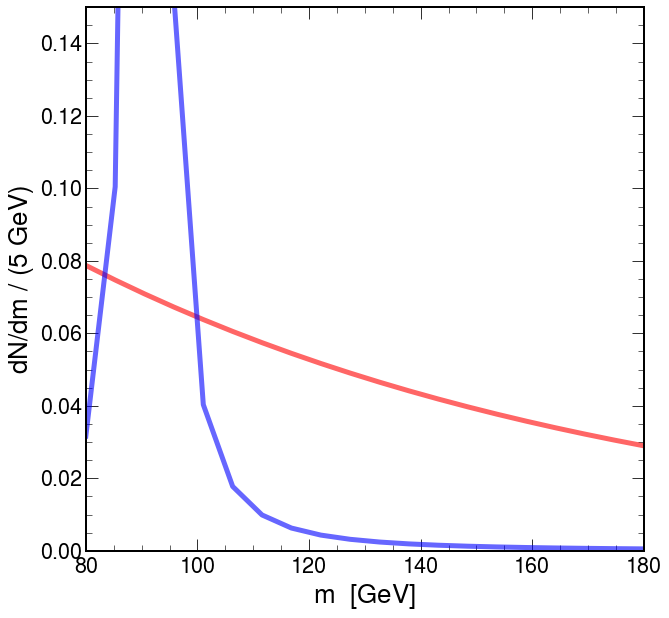

In [15]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
ylims=(0.0, 0.15)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.plot(x, pdf_fakes, 'r-', lw=5, alpha=0.6, label='fakes')
ax.plot(x, pdf_Z, 'b-', lw=5, alpha=0.6, label='Z')

In [16]:
# make DataGenerator with mixture of pdfs
bkg_funcs = [func_Z, func_fakes]
bkg_mixtures = [f_Z, f_fakes]
bkg_gen = hep.data.DataGenerator(funcs=bkg_funcs, mixtures=bkg_mixtures)
bkg_pdf = bkg_gen.get_pdf(x)
assert np.allclose(bkg_pdf, pdf_tot1)

In [17]:
sig_gens = [ hep.data.DataGenerator(funcs=[_func], mixtures=[1.0]) for _func in signal_funcs ]

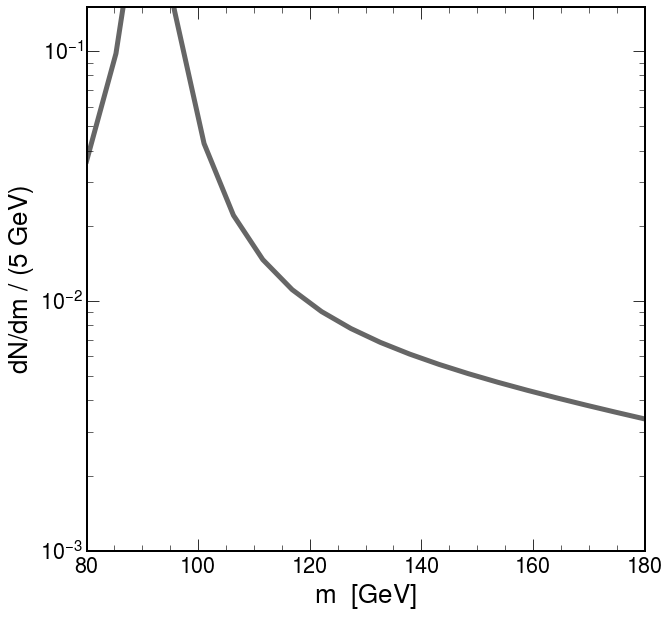

In [18]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
#ylims=(0.0, 0.15)
ylims=(1e-3, 0.15) # logy
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_yscale('log')
ax.plot(x, bkg_pdf, 'k-', lw=5, alpha=0.6, label='pdf')

## Monte Carlo for the model

In [19]:
a_test = bkg_gen.generate(10000, i=1)
y_test = np.histogram(a_test, bins=n_xbins, range=(x_min, x_max))

In [20]:
y_test

(array([488, 469, 444, 392, 429, 428, 368, 326, 303, 280, 297, 276, 248,
        273, 240, 251, 247, 229, 192, 197]),
 array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120., 125., 130.,
        135., 140., 145., 150., 155., 160., 165., 170., 175., 180.]))

In [21]:
bins = list(y_test[1])

In [22]:
n_bkgs = bkg_gen.get_n()
assert len(bkg_sigmas) == n_bkgs
n_mcs = [int(1e4), int(1e4)]
bkg_hists = [ np.histogram(bkg_gen.generate(n_mcs[_i], i=_i), bins=n_xbins, range=(x_min, x_max))[0] for _i in range(n_bkgs)]
bkg_scales = [ bkg_sigmas[_i]*LUMI/n_mcs[_i] for _i in range(n_bkgs) ]
bkg_hists = [ list(bkg_hists[_i] * bkg_scales[_i]) for _i in range(n_bkgs) ]


In [23]:
bins = [ float(_b) for _b in y_test[1] ]
y = bkg_hists
xlabel = '$m$  [GeV]'
ylabel = 'Events / (5 GeV)'
labels = ['Z','Fakes']
ytotal  = [sum(_y) for _y in zip(*y)]

## gaussian errors
yerr    = [
    math.sqrt(_y) for _y in ytotal
]
# TODO: yerr should be better that sqrt(n)

In [24]:
#n_signals = [50]*len(signal_masses) # TODO: use signal_sigmas
n_signals = [ int(round(s*LUMI)) for s in signal_sigmas ]
signal_grid = dict()
for _m, _sg, _n in zip(signal_masses, sig_gens, n_signals):
    _x = _sg.generate(_n)
    signal_grid[(_m,)] = list(np.histogram(_x, bins=n_xbins, range=(x_min, x_max))[0])

In [25]:
signals = list(signal_grid.values())
signal_points = list(signal_grid.keys())

In [26]:
n_data = 10000
data = list(np.histogram(bkg_gen.generate(n_data), bins=n_xbins, range=(x_min, x_max))[0])
data_label='Data'

## Histograms

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (5 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

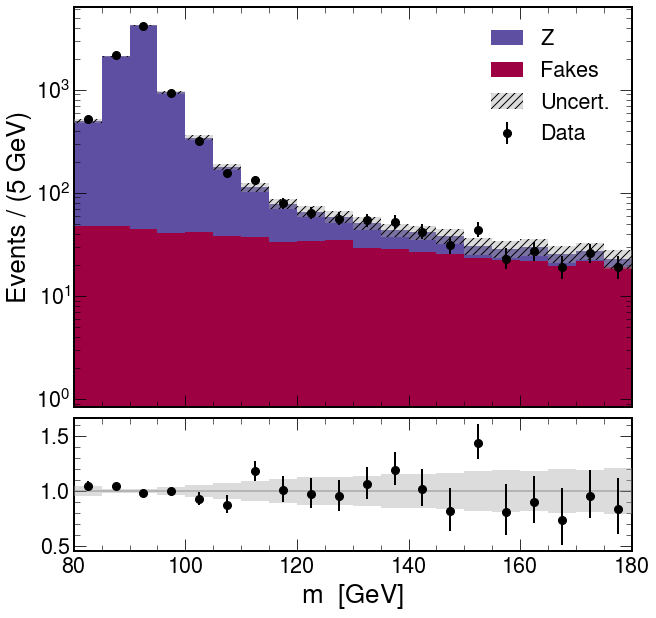

In [27]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(x_min, x_max),
#                ylim=(10., 1e4),
                yscale='log',
                ratio=True)

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (5 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

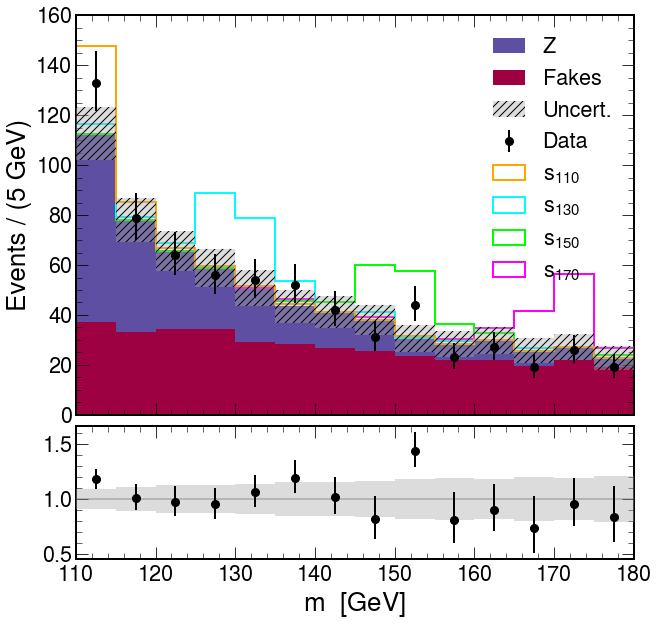

In [28]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                signals=signals,
                signal_labels=signal_labels,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(110, 180),
                ylim=(0.0, 160.0),
                ratio=True,
                stack_signals=True)

## Hypothesis testing with pyhf

### TODO:

-   Explain `pyhf.simplemodels.hepdata_like`
    -   Marked Poisson
    -   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>

## Basic hypothesis test at mu=1.0

In [29]:
list_of_results = list()
for i_signal, signal in enumerate(signals):
    print('Testing signal %i' % (i_signal+1))
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    CLs_obs, CLs_exp_band = hep.stats.hypo_test(pdf=pdf, data=data, mu=1.0)
    results = dict()
    results['pdf'] = pdf
    results['CLs_obs'] = CLs_obs
    results['CLs_exp_band'] = CLs_exp_band
    list_of_results.append(results)
    print('Expected CLs -2 sigma: %.4f' % (CLs_exp_band[0]))
    print('Expected CLs -1 sigma: %.4f' % (CLs_exp_band[1]))
    print('Expected CLs         : %.4f' % (CLs_exp_band[2]))
    print('Expected CLs +1 sigma: %.4f' % (CLs_exp_band[3]))
    print('Expected CLs +2 sigma: %.4f' % (CLs_exp_band[4]))
    print('Observed CLs         : %.4f' % (CLs_obs))
    print('')

Testing signal 1
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0001
Expected CLs         : 0.0018
Expected CLs +1 sigma: 0.0205
Expected CLs +2 sigma: 0.1359
Observed CLs         : 0.0027

Testing signal 2
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0001
Expected CLs +1 sigma: 0.0015
Expected CLs +2 sigma: 0.0220
Observed CLs         : 0.0001

Testing signal 3
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0008
Expected CLs +2 sigma: 0.0145
Observed CLs         : 0.0001

Testing signal 4
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0003
Expected CLs +2 sigma: 0.0059
Observed CLs         : 0.0000



## Hypothesis test scan for a single signal

In [30]:
pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signals[0])
mu_bounds = (0, 5)
test_size = 0.05
cls_obs, cls_exp, test_mus = hep.stats.hypo_test_scan(pdf, 
                                                      data, 
                                                      mu_bounds=mu_bounds)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\mu$', ylabel='$\\mathrm{CLs}$'>)

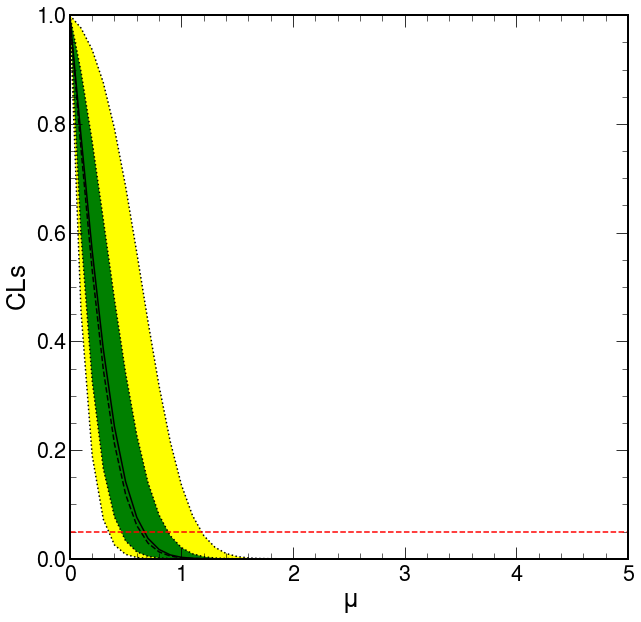

In [31]:
hep.plot.brazil(x=test_mus, exp=cls_exp, obs=cls_obs,
                     xlabel=r'$\mu$',
                     ylabel=r'$\mathrm{CLs}$',
                     xlim=mu_bounds,
                     ylim=(0.0, 1.0),
                     yline=test_size,
                     )

In [32]:
hep.stats.invert_interval(cls_obs, cls_exp, test_mus, test_size=test_size)

(0.6680740226319222,
 [0.3480507121794068,
  0.4613076737060473,
  0.634568380503475,
  0.8797796410912582,
  1.1803208667176655])

## Hypothesis test scan across signals

In [33]:
signal_ms = list()
exclusions_obs = list()
exclusions_exp = list()
for signal_point, signal in signal_grid.items():
    assert len(signal_point) == 1
    signal_ms.append(signal_point[0])
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    cls_obs, cls_exp, test_mus = hep.stats.hypo_test_scan(pdf, 
                                                          data, 
                                                          mu_bounds=mu_bounds)
    mu_excl_obs, mu_excl_exp = hep.stats.invert_interval(cls_obs, cls_exp, test_mus, test_size=test_size)
    exclusions_obs.append(mu_excl_obs)
    exclusions_exp.append(mu_excl_exp)

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/infer/calculators.py:369: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta$', ylabel='$\\mu\\ \\mathrm{excluded\\ at\\ 95\\%\\ CL}$'>)

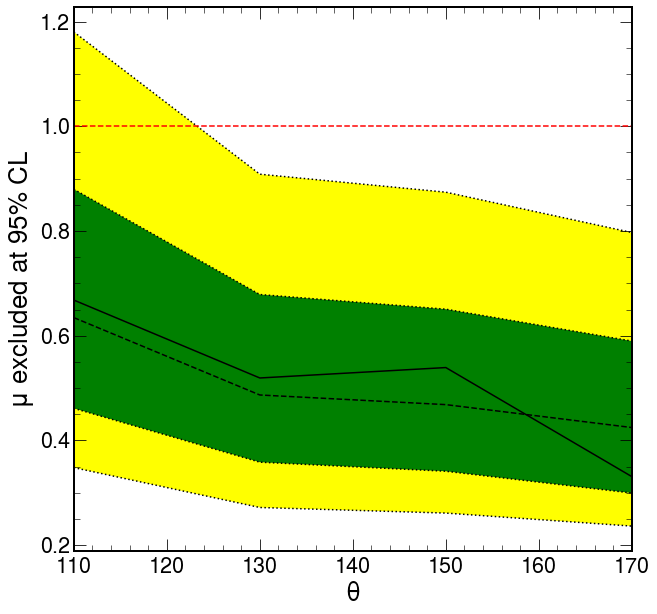

In [34]:
hep.plot.brazil(x=signal_ms, exp=exclusions_exp, obs=exclusions_obs,
                xlabel=r'$\theta$  [GeV]',
                ylabel=r'$\mu\ \mathrm{excluded\ at\ 95\%\ CL}$',
                yline=1.0,)

## Injecting signal

In [35]:
# signal injection
sig_func = signal_funcs[2]
sig_sigma = signal_sigmas[2]
injection_funcs = bkg_funcs + [sig_func]
pdf_sig = sig_func.pdf(x)

sigma_tot2 = sigma_Z + sigma_fakes + sig_sigma
f_Z2 = sigma_Z / sigma_tot2
f_fakes2 = sigma_fakes / sigma_tot2
f_sig2 = sig_sigma / sigma_tot2

injection_mixtures = [f_Z2, f_fakes2, f_sig2]
pdf_tot2 = f_Z2*pdf_Z + f_fakes2*pdf_fakes + f_sig2*pdf_sig
injection_gen = hep.data.DataGenerator(funcs=injection_funcs, mixtures=injection_mixtures)

In [36]:
injection_mixtures

[0.8933002481389578, 0.09925558312655088, 0.007444168734491315]

In [37]:
sigma_tot2, sigma_Z, sigma_fakes, sig_sigma

(10075.0, 9000.0, 1000.0, 75.0)

In [38]:
n_data2 = 10000
data2 = list(np.histogram(injection_gen.generate(n_data2), bins=n_xbins, range=(x_min, x_max))[0])

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (5 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

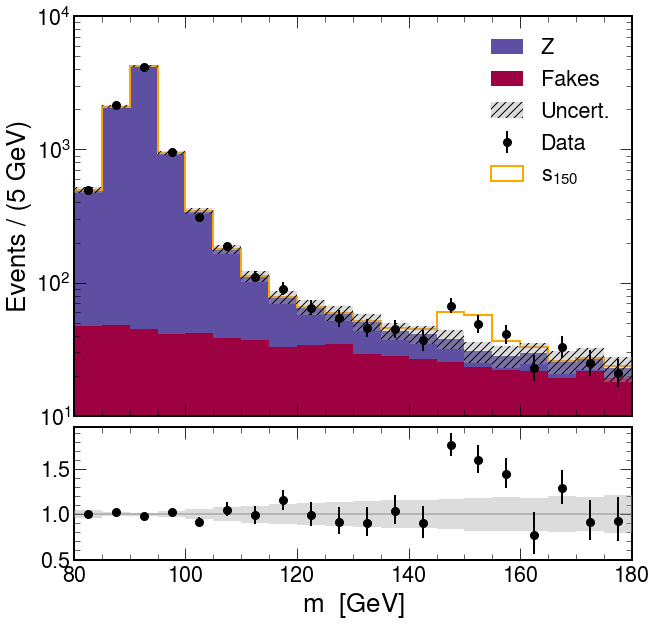

In [39]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data2,
                data_label=data_label,
                signals=[signals[2]],
                signal_labels=[signal_labels[2]],
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(x_min, x_max),
                ylim=(10., 1e4),
                yscale='log',
                ratio=True)

(<Figure size 720x720 with 2 Axes>,
 [<AxesSubplot:ylabel='Events / (5 GeV)'>, <AxesSubplot:xlabel='$m$  [GeV]'>])

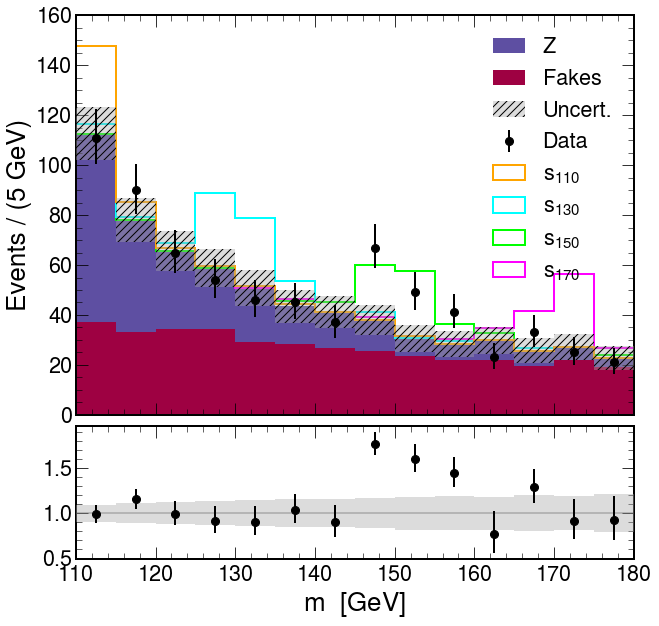

In [40]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data2,
                data_label=data_label,
                signals=signals,
                signal_labels=signal_labels,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(110, 180),
                ylim=(0.0, 160.0),
                ratio=True,
                stack_signals=True)

In [41]:
signal_ms = list()
exclusions_obs = list()
exclusions_exp = list()
for signal_point, signal in signal_grid.items():
    assert len(signal_point) == 1
    signal_ms.append(signal_point[0])
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    cls_obs, cls_exp, test_mus = hep.stats.hypo_test_scan(pdf, 
                                                          data2, 
                                                          mu_bounds=mu_bounds)
    mu_excl_obs, mu_excl_exp = hep.stats.invert_interval(cls_obs,
                                                         cls_exp,
                                                         test_mus,
                                                         test_size=test_size)
    exclusions_obs.append(mu_excl_obs)
    exclusions_exp.append(mu_excl_exp)

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/infer/calculators.py:369: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta$', ylabel='$\\mu\\ \\mathrm{excluded\\ at\\ 95\\%\\ CL}$'>)

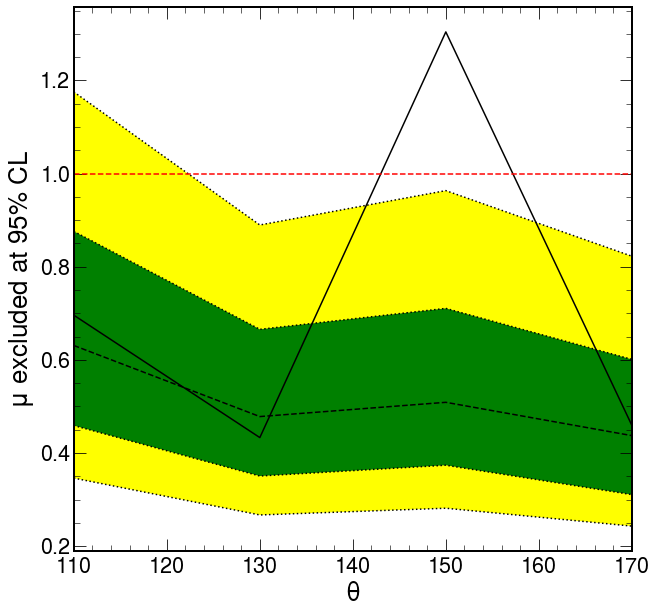

In [42]:
hep.plot.brazil(x=signal_ms, exp=exclusions_exp, obs=exclusions_obs,
                xlabel=r'$\theta$  [GeV]',
                ylabel=r'$\mu\ \mathrm{excluded\ at\ 95\%\ CL}$',
                yline=1.0,)

## Calculate $p_0$ for discovery

In [43]:
signal_ms = list()
p0s_obs = list()
p0s_exp = list()
for signal_point, signal in signal_grid.items():
    assert len(signal_point) == 1
    signal_ms.append(signal_point[0])
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    p0_results = hep.stats.discovery_p0(pdf, data2)
    q0, q0_exp_band, z0_obs, z0_exp_band, p0_obs, p0_exp_band = p0_results
    p0s_obs.append(p0_obs)
    p0s_exp.append(p0_exp_band)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta$', ylabel='Local $p_{0}$'>)

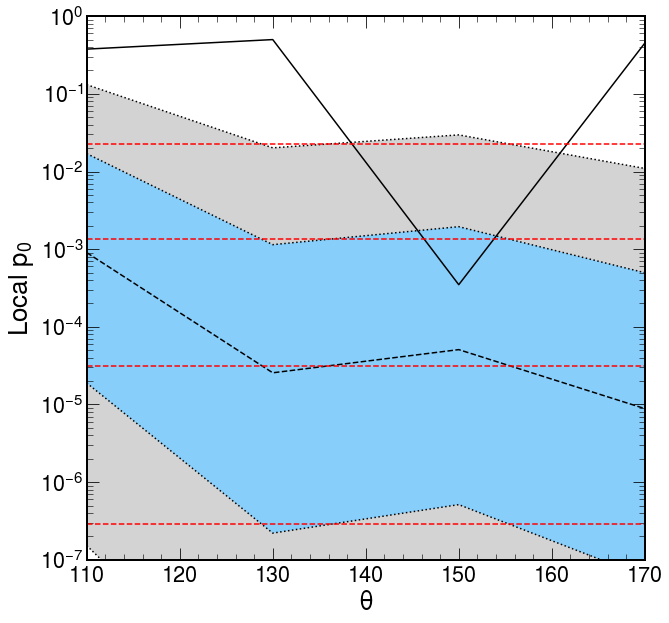

In [44]:
hep.plot.brazil(x=signal_ms, exp=p0s_exp, obs=p0s_obs,
                xlabel=r'$\theta$  [GeV]',
                ylabel=r'Local $p_{0}$',
                ylim=(1e-7, 1.0),
                yscale='log',
                yline=[1.0-scipy.stats.norm.cdf(z) for z in [2, 3, 4, 5]],
                fillstyle='bluegray',
                )

## Measure best-fit signal strength

In [66]:
signal = signal_grid[(150.0,)]
pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)

In [67]:
def twice_nll_scan(pdf, 
                   data,
                   test_mus=None,
                   init_pars=None,
                   par_bounds=None,
                   mu_bounds=None,
                   mu_step=0.1,
                   deltaL=True,
                   ):
    if init_pars is None:
        init_pars = pdf.config.suggested_init()
    if par_bounds is None:
        par_bounds = pdf.config.suggested_bounds()
    params_mle, twice_nll_mle = pyhf.infer.mle.fit(data=data + pdf.config.auxdata,
                                               pdf=pdf, 
                                               init_pars=init_pars, 
                                               par_bounds=par_bounds,
                                               return_fitted_val=True,
                                              )
    mu_mle = params_mle[pdf.config.poi_index]
    
    if mu_bounds is None:
        mu_bounds = par_bounds[pdf.config.poi_index]
    else:
        par_bounds[pdf.config.poi_index] = mu_bounds
    
    if test_mus is None:
        mu_steps = int(round(abs(float(mu_bounds[1] - mu_bounds[0]))/mu_step)) + 1
        test_mus = np.linspace(mu_bounds[0], mu_bounds[1], mu_steps)
        
    twice_nll_results = [
        pyhf.infer.mle.fixed_poi_fit(poi_val=mu,
                                       data=data2 + pdf.config.auxdata,
                                       pdf=pdf,
                                       init_pars=init_pars,
                                       par_bounds=par_bounds,
                                       return_fitted_val=True,
                                      )
        for mu in test_mus
    ]
    # convert twice_nll_results from
    # [ (params, twice_nll), ...]
    # to twice_nlls
    # [twice_nll, ...]
    twice_nlls = [tnll for _, tnll in twice_nll_results]
    # convert -2 ln L to -2 Delta ln L
    _x = test_mus
    _y = twice_nlls
    min_y = min(_y)
    i_hat = _y.index(min_y)
    x_hat = _x[i_hat]
    if deltaL:
        _y = [ yi-min_y for yi in _y]
        x_hat_m1 = np.interp(
            1.0, list(reversed(_y[:i_hat+1])), list(reversed(_x[:i_hat+1]))
        )
        x_hat_p1 = np.interp(
            1.0, _y[i_hat:], _x[i_hat:]
        )
        x_hat_band = [x_hat_m1, x_hat, x_hat_p1]
        return _y, _x, x_hat_band
    return _y, _x,

In [68]:
def plot_twice_nll(x, y,
           xlabel=None,
           ylabel=None,
           xlim=None,
           ylim=None,
           yline=None,
           yscale=None,
           ):
    fig, ax = plt.subplots()
    ax.plot(x, y, c='black')
    if yline is not None:
        if not isinstance(yline, list):
            ylines = [yline]
        else:
            ylines = yline
        for _yl in ylines:
            ax.plot(x, [_yl] * len(x), color='red', linestyle='dashed')
    if not xlim is False:
        xlim = (x[0], x[-1])
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    if yscale:
        ax.set_yscale('log')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    return fig, ax

In [71]:
twice_nlls, test_mus, mu_hat_band = twice_nll_scan(pdf, 
                   data2,
                   mu_bounds=(-0.5, 2.0),
                   mu_step=0.05,
                   )

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:352: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\mu$', ylabel='$-2 \\Delta \\mathrm{ln} \\lambda(\\mu)$'>)

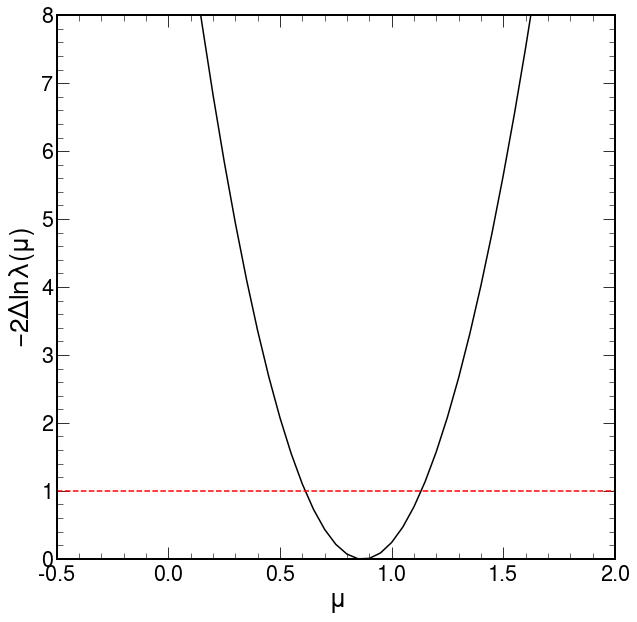

In [72]:
plot_twice_nll(test_mus, twice_nlls,
              xlabel='$\mu$',
              ylabel='$-2 \Delta \mathrm{ln} \lambda(\mu)$',
              ylim=(0, 8),
              yline=1,
              )

In [73]:
signal_ms = list()
mu_hat_results = list()
for signal_point, signal in signal_grid.items():
    assert len(signal_point) == 1
    signal_ms.append(signal_point[0])
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    twice_nlls, test_mus, mu_hat_band = twice_nll_scan(pdf, 
                   data2,
                   mu_bounds=(-0.5, 2.0),
                   mu_step=0.05,
                   )
    mu_hat_results.append(mu_hat_band)

/home/ryan/at-github/statistics-notebooks/env1/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:352: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [74]:
mu_hat_results

[[-0.21758014816846882, 0.10000000000000009, 0.4176288023953271],
 [-0.3144184993727611, -0.04999999999999999, 0.1649197326829773],
 [0.6134040930579402, 0.8500000000000001, 1.1317929706255885],
 [-0.1892244763548127, 0.050000000000000044, 0.2463387441687237]]

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta$  [GeV]', ylabel='Signal strength $(\\hat{\\mu})$'>)

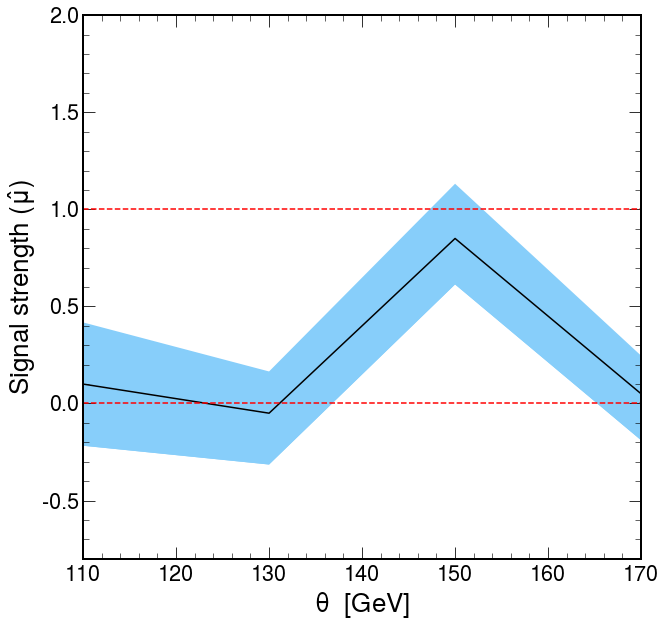

In [76]:
hep.plot.brazil(x=signal_ms, obs=mu_hat_results,
                xlabel=r'$\theta$  [GeV]',
                ylabel=r'Signal strength $(\hat{\mu})$',
                ylim=(-0.8, 2.0),
                yline=[0.0, 1.0],
                fillstyle='blue',
                )

## TODO: Learn about these

In [53]:
best_fit = pyhf.infer.mle.fit(data + pdf.config.auxdata, pdf)

In [54]:
best_fit

array([3.40743933e-15, 1.02429918e+00, 1.02164178e+00, 9.90445159e-01,
       9.98352533e-01, 9.65926196e-01, 9.38200908e-01, 1.09058829e+00,
       1.00576602e+00, 9.87057050e-01, 9.76195188e-01, 1.03254138e+00,
       1.09770012e+00, 1.00970851e+00, 9.07885131e-01, 1.21895870e+00,
       9.04925893e-01, 9.51511012e-01, 8.69650252e-01, 9.76189003e-01,
       9.16664383e-01])

In [55]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.infer.mle.fit(data + pdf.config.auxdata, pdf)

In [56]:
background_only

[0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [57]:
nominal

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [58]:
pdf.config.par_names()

['mu',
 'uncorr_bkguncrt[0]',
 'uncorr_bkguncrt[1]',
 'uncorr_bkguncrt[2]',
 'uncorr_bkguncrt[3]',
 'uncorr_bkguncrt[4]',
 'uncorr_bkguncrt[5]',
 'uncorr_bkguncrt[6]',
 'uncorr_bkguncrt[7]',
 'uncorr_bkguncrt[8]',
 'uncorr_bkguncrt[9]',
 'uncorr_bkguncrt[10]',
 'uncorr_bkguncrt[11]',
 'uncorr_bkguncrt[12]',
 'uncorr_bkguncrt[13]',
 'uncorr_bkguncrt[14]',
 'uncorr_bkguncrt[15]',
 'uncorr_bkguncrt[16]',
 'uncorr_bkguncrt[17]',
 'uncorr_bkguncrt[18]',
 'uncorr_bkguncrt[19]']

In [59]:
par_bounds = pdf.config.suggested_bounds()

In [60]:
par_bounds

[(0, 10),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0),
 (1e-10, 10.0)]

In [61]:
unconpars = pyhf.infer.mle.fit(data + pdf.config.auxdata, pdf, nominal, par_bounds)
print("parameters post unconstrained fit: {}".format(unconpars))

parameters post unconstrained fit: [3.40743933e-15 1.02429918e+00 1.02164178e+00 9.90445159e-01
 9.98352533e-01 9.65926196e-01 9.38200908e-01 1.09058829e+00
 1.00576602e+00 9.87057050e-01 9.76195188e-01 1.03254138e+00
 1.09770012e+00 1.00970851e+00 9.07885131e-01 1.21895870e+00
 9.04925893e-01 9.51511012e-01 8.69650252e-01 9.76189003e-01
 9.16664383e-01]


In [62]:
conpars = pyhf.infer.mle.fixed_poi_fit(0.0, data + pdf.config.auxdata, pdf, nominal, par_bounds)
print("parameters post constrained fit: {}".format(conpars))

parameters post constrained fit: [0.         1.02430004 1.0216419  0.99044551 0.99835367 0.96593245
 0.93820784 1.09058248 1.00576026 0.98706133 0.97618342 1.03254062
 1.09770737 1.00971908 0.90788948 1.21896738 0.90492557 0.95152157
 0.86963967 0.97618765 0.91666293]


In [63]:
pdf.expected_data(conpars)

array([ 507.95038889, 2145.55016316, 4167.20042357,  939.55063661,
        331.70120485,  167.00099575,  122.79958694,   78.54987621,
         64.8499295 ,   57.39958535,   52.34980955,   47.75027062,
         41.60042615,   34.4998002 ,   37.30040177,   25.69988627,
         28.450495  ,   22.34973947,   26.64992296,   20.89991484,
        507.95038889, 2145.55016316, 4167.20042357,  939.55063661,
        331.70120485,  167.00099575,  122.79958694,   78.54987621,
         64.8499295 ,   57.39958535,   52.34980955,   47.75027062,
         41.60042615,   34.4998002 ,   37.30040177,   25.69988627,
         28.450495  ,   22.34973947,   26.64992296,   20.89991484])

In [64]:
pdf.config.poi_index

0

## See also

-   Cranmer, K. (2020). [Thumbnail of LHC statistical procedures](http://theoryandpractice.org/stats-ds-book/statistics/lhc_stats_thumbnail.html).
-   Cowan, G. et al. (2010). Asymptotic formulae for likelihood-based tests of new physics. https://arxiv.org/abs/1007.1727
-   https://pyhf.github.io/pyhf-tutorial/HelloWorld.html
-   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>
-   Heinrich, L., Feickert, M., & Stark, G. (2018). [pyhf](https://github.com/scikit-hep/pyhf). <https://scikit-hep.org/pyhf/>
-   Feickert, M. (2018). pyhf: a pure Python implementation of HistFactory with tensors and autograd. <https://indico.cern.ch/event/759480/>
-   <https://github.com/CoffeaTeam/coffea/blob/master/coffea/hist/plot.py>
-   <https://scikit-hep.org/pyhf/examples/notebooks/multichannel-coupled-histo.html>
-   <https://scikit-hep.org/pyhf/examples/notebooks/binderexample/StatisticalAnalysis.html>

![](http://theoryandpractice.org/stats-ds-book/_images/LHC-stats-thumbnail.001.png)